In [1]:
import random
import copy
from collections import OrderedDict

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from util import view_10, num_params
from data import fetch_dataset, data_to_tensor, iid_partition_loader, noniid_partition_loader

In [2]:
# set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print("| using device:", device)


| using device: cuda


In [3]:
# hyperparams
bsz = 10

## Data

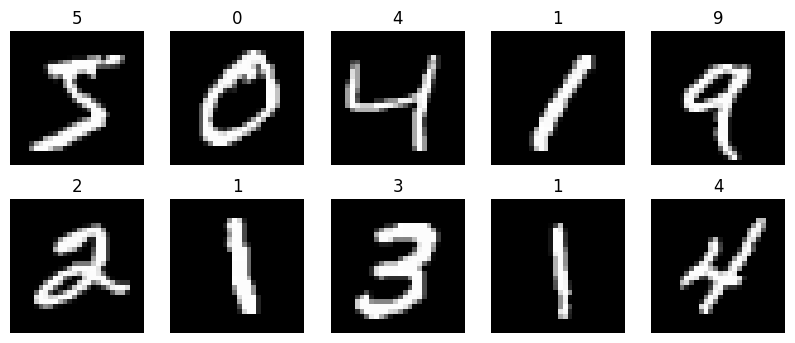

In [4]:
train_data, test_data = fetch_dataset()

test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle=False) # inference bsz=1000
debug_loader = torch.utils.data.DataLoader(train_data, bsz)
img, label = next(iter(debug_loader))
view_10(img, label)

In [5]:
# get client dataloaders
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)
noniid_client_train_loader = noniid_partition_loader(train_data, bsz = bsz)

iid:  tensor([59., 67., 65., 61., 55., 52., 55., 64., 48., 74.])


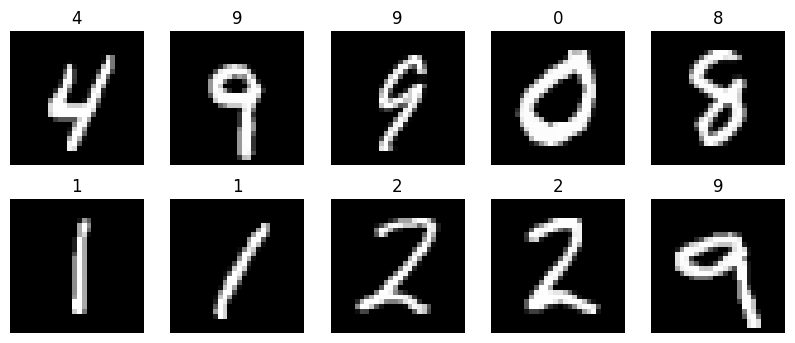

In [6]:
# iid
label_dist = torch.zeros(10)
for (x,y) in iid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y, num_classes=10), dim=0)
print("iid: ", label_dist)
view_10(x,y)

non-iid:  tensor([300.,   0.,   0., 300.,   0.,   0.,   0.,   0.,   0.,   0.])


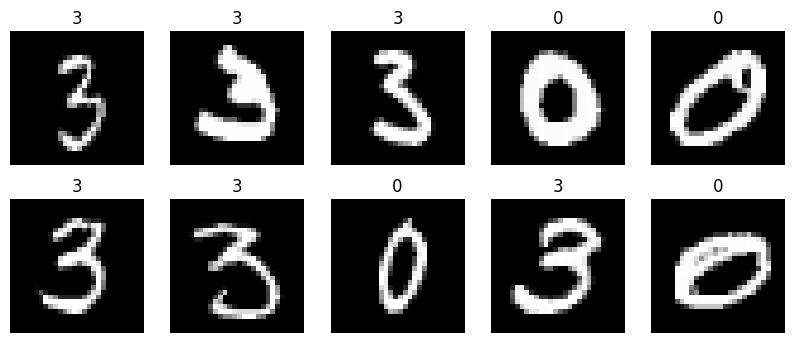

In [7]:
# non-iid
label_dist = torch.zeros(10)
for (x,y) in noniid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y,num_classes=10), dim=0)
print("non-iid: ", label_dist)
view_10(x,y)

## Models

In [8]:
# define fully connected NN
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 200);
        self.fc2 = nn.Linear(200, 200);
        self.out = nn.Linear(200, 10);

    def forward(self, x):
        x = x.flatten(1) # [B x 784]
        x = F.relu(self.fc1(x)) # [B x 200]
        x = F.relu(self.fc2(x)) # [B x 200]
        x = self.out(x) # [B x 10]
        return x

print(MLP())
print(num_params(MLP()))

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
199210


In [9]:
# define cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) 
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2, 2) # [B x 32 x 12 x 12]
        x = F.max_pool2d(self.conv2(x), 2, 2) # [B x 64 x 4 x 4]
        x = x.flatten(1) # [B x 1024]
        x = F.relu(self.fc(x)) # [B x 512]
        x = self.out(x) # [B x 10]
        return x

print(CNN())
print(num_params(CNN()))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)
582026


In [10]:
# define MetaModel
class MetaModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MetaModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training

In [11]:
criterion = nn.CrossEntropyLoss()

def validate(model):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            correct += torch.sum(torch.argmax(out, dim=1) == y).item()
            total += x.shape[0]
    return correct/total

In [12]:
def get_flattened_params(model):
    # param_dict = OrderedDict()
    params = []
    for name,param in model.named_parameters():
        # param_dict[name] = param.data.view(-1)
        params.append(param.data.view(-1))
    return torch.cat(params)

def get_flattened_params_P(modelP):
    # param_dict = OrderedDict()
    batch_P = []
    for k in modelP:
        cP = modelP[k]
        params = []
        for name,param in cP:
            # param_dict[name] = param.data.view(-1)
            params.append(param.data.view(-1))
        allP = torch.cat(params)
        aP = allP.unsqueeze(0)
        batch_P.append(aP)
    return torch.cat(batch_P,dim=0)

def set_flattened_params(model, flaP):
    params = {}
    idx = 0
    for name, param in model.named_parameters():
        shape = param.shape
        size = torch.prod(torch.tensor(shape)).item()
        flaP = torch.mean(flaP,dim=0,keepdim=True)
        f = flaP[:,idx:idx+size]
        # print(size,param.size(),flaP.size(),f.size())
        params[name] = f.view(param.size()).to(device)
        idx += size
    return params

In [13]:
def train_client(id, client_loader, global_model, num_local_epochs, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(client_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = local_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    return local_model

def train_meta(global_model, opt,criterion):
    model = global_model.to(device)
    model.train()
    optimizer = opt
    lossm = []
    accm = []
    for (i, (x,y)) in enumerate(test_loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        # Compute accuracy
        _, predicted = torch.max(out.data, 1)
        correct = (predicted == y).sum().item()
        accuracy = correct / y.size(0)
        
        loss.backward()
        opt.step()
        lossm.append(loss.item())
        accm.append(accuracy)

    return sum(accm)/len(accm),sum(lossm)/len(lossm)

def running_model_avg(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current

def running_metamodel(local_p,meta_model):
    fla_P = get_flattened_params_P(local_p)
    meta_P = meta_model(fla_P)
    return meta_P

In [14]:
def fed_meta_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds, filename,metaModel=None,opt=None):
    round_accuracy = []
    meta_criterion = nn.CrossEntropyLoss()
    for t in range(max_rounds):
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(100), num_clients_per_round, replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)
        running_meta = {}
        for i,c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients_per_round, c))
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)
            
            running_meta[c] = local_model.named_parameters()
        
        metaP = running_metamodel(running_meta,metaModel)
        # set global model parameters for the next step
        global_model.load_state_dict(set_flattened_params(local_model, metaP))

        acc,meta_loss = train_meta(global_model,opt,meta_criterion)
        
        # validate
        val_acc = validate(global_model)
        print(f"round {t} | validation acc: {val_acc} | meta m-acc:{acc} and  m-loss:{meta_loss}")
        round_accuracy.append(val_acc)

        if (t % 10 == 0):
          np.save(filename+'_{}'.format(t)+'.npy', np.array(round_accuracy))

    return np.array(round_accuracy)

def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds, filename):
    round_accuracy = []
    for t in range(max_rounds):
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(100), num_clients_per_round, replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)
        running_avg = None

        for i,c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients_per_round, c))
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

            # add local model parameters to running average
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1/num_clients_per_round)
        
        # set global model parameters for the next step
        global_model.load_state_dict(running_avg)

        # validate
        val_acc = validate(global_model)
        print("round {}, validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if (t % 10 == 0):
          np.save(filename+'_{}'.format(t)+'.npy', np.array(round_accuracy))

    return np.array(round_accuracy)




 ## MLP experiments

In [15]:
mlp = MLP()
print(mlp)
print("total params: ", num_params(mlp))

input_size = get_flattened_params(mlp).numel()
mModel = MetaModel(input_size,input_size).to(device)
optimizer_meta = optim.Adam(mModel.parameters(), lr=1e-4)

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
total params:  199210


In [16]:
# MLP - iid - m=10 experiment
mlp_iid_m10 = copy.deepcopy(mlp)
acc_mlp_iid_m10 = fed_meta_experiment(mlp_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=50,
                                 filename='./acc_mlp_iid_m10',metaModel=mModel,opt=optimizer_meta)
print(acc_mlp_iid_m10)
# np.save('./acc_mlp_iid_m10.npy', acc_mlp_iid_m10)

starting round 0
clients:  [26 86  2 55 75 93 16 73 54 95]
round 0, starting client 1/10, id: 26
round 0, starting client 2/10, id: 86
round 0, starting client 3/10, id: 2
round 0, starting client 4/10, id: 55
round 0, starting client 5/10, id: 75
round 0, starting client 6/10, id: 93
round 0, starting client 7/10, id: 16
round 0, starting client 8/10, id: 73
round 0, starting client 9/10, id: 54
round 0, starting client 10/10, id: 95
round 0 | validation acc: 0.114 | meta m-acc:0.11399999999999996 and  m-loss:2.2975586891174316
starting round 1
clients:  [18 29 64 92 72 87  5 15 12 17]
round 1, starting client 1/10, id: 18
round 1, starting client 2/10, id: 29
round 1, starting client 3/10, id: 64
round 1, starting client 4/10, id: 92
round 1, starting client 5/10, id: 72
round 1, starting client 6/10, id: 87
round 1, starting client 7/10, id: 5
round 1, starting client 8/10, id: 15
round 1, starting client 9/10, id: 12
round 1, starting client 10/10, id: 17
round 1 | validation acc: 

KeyboardInterrupt: 

In [ ]:
# MLP - iid - m=10 experiment
mlp_iid_m10 = copy.deepcopy(mlp)
acc_mlp_iid_m10 = fed_avg_experiment(mlp_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=10,
                                 filename='./acc_mlp_iid_m10')
# print(acc_mlp_iid_m10)
# np.save('./acc_mlp_iid_m10.npy', acc_mlp_iid_m10)

In [ ]:
# MLP - iid - m=50 experiment
mlp_iid_m50 = copy.deepcopy(mlp)
acc_mlp_iid_m50 = fed_avg_experiment(mlp_iid_m50, num_clients_per_round=50, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=10,
                                 filename='./acc_mlp_iid_m50')
print(acc_mlp_iid_m50)
np.save('./acc_mlp_iid_m50.npy', acc_mlp_iid_m50)

In [ ]:
# MLP - non-iid - m=10 experiment
mlp_noniid_m10 = copy.deepcopy(mlp)
acc_mlp_noniid_m10 = fed_avg_experiment(mlp_noniid_m10, num_clients_per_round=10, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename = './acc_mlp_noniid_m10')
print(acc_mlp_noniid_m10)
np.save('./acc_mlp_noniid_m10.npy', acc_mlp_noniid_m10)

In [ ]:
# MLP - noniid - m=50 experiment
mlp_noniid_m50 = copy.deepcopy(mlp)
acc_mlp_noniid_m50 = fed_avg_experiment(mlp_noniid_m50, num_clients_per_round=50, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_mlp_noniid_m50')
print(acc_mlp_noniid_m50)
np.save('./acc_mlp_noniid_m50.npy', acc_mlp_noniid_m50)

## CNN Experiments

In [47]:
cnn = CNN()
print(cnn)
print("total params: ", num_params(cnn))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)
total params:  582026


In [48]:
# 获取参数字典
params_dict = get_flattened_params(cnn)

for k in params_dict:
    print(f'{k}:{params_dict[k].size()}')

conv1.weight:torch.Size([800])
conv1.bias:torch.Size([32])
conv2.weight:torch.Size([51200])
conv2.bias:torch.Size([64])
fc.weight:torch.Size([524288])
fc.bias:torch.Size([512])
out.weight:torch.Size([5120])
out.bias:torch.Size([10])


In [ ]:
# CNN - iid - m=10 experiment
cnn_iid_m10 = copy.deepcopy(cnn)
acc_cnn_iid_m10 = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=10,
                                 filename='./acc_cnn_iid_m10')
print(acc_cnn_iid_m10)
np.save('./acc_cnn_iid_m10.npy', acc_cnn_iid_m10)

In [ ]:
# CNN - iid - m=50 experiment
cnn_iid_m50 = copy.deepcopy(cnn)
acc_cnn_iid_m50 = fed_avg_experiment(cnn_iid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=5,
                                 filename='./acc_cnn_iid_m50')
print(acc_cnn_iid_m50)
np.save('./acc_cnn_iid_m50.npy', acc_cnn_iid_m50)

In [ ]:
# CNN - non-iid - m=10 experiment
cnn_noniid_m10 = copy.deepcopy(cnn)
acc_cnn_noniid_m10 = fed_avg_experiment(cnn_noniid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=200,
                                 filename='./acc_cnn_noniid_m10')
print(acc_cnn_noniid_m10)
np.save('./acc_cnn_noniid_m10.npy', acc_cnn_noniid_m10)

In [ ]:
# CNN - non-iid - m=50 experiment
cnn_noniid_m50 = copy.deepcopy(cnn)
acc_cnn_noniid_m50 = fed_avg_experiment(cnn_noniid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_noniid_m50')
print(acc_cnn_noniid_m50)
np.save('./acc_cnn_noniid_m50.npy', acc_cnn_noniid_m50)

In [ ]:
# view_10(x_debug[:10].to(cpu), torch.argmax(model(x_debug),dim=1)[:10].to(cpu))

# m = CNN().to(device)
# m.train()
# lr = 0.01
# opt = torch.optim.SGD(m.parameters(), lr)

# for epoch in range(5):
#     for (t, (x,y)) in enumerate(train_loader):
#         x = x.to(device)
#         y = y.to(device)
#         opt.zero_grad()
#         out = m(x)
#         loss = criterion(out, y)
#         loss.backward()
#         opt.step()

#         if (t%100 == 0):
#             print("epoch {}, step {}, loss: {}".format(epoch, t, loss))

#     print("running validation")
#     acc = validate(m)
#     print("epoch {} validation acc: {}".format(epoch, acc))